# Customer Churn Demo

In this notebook you will learn how to build a predictive model with Spark machine learning API (SparkML) to predict customer churn, and deploy it for scoring in Machine Learning (ML). 

This notebook walks you through these steps:
- Build a model with SparkML API
- Save the model in the ML repository
- Create a Deployment in ML (via UI)
- Test the model (via UI)
- Test the model (via REST API)

## Use Case

The analytics use case implemented in this notebook is telco churn. While it's a simple use case, it implements all steps from the CRISP-DM methodolody, which is the recommended best practice for implementing predictive analytics. 
![CRISP-DM](https://raw.githubusercontent.com/yfphoon/dsx_demo/master/crisp_dm.png)

The analytics process starts with defining the business problem and identifying the data that can be used to solve the problem. For Telco churn, we use demographic and historical transaction data. We also know which customers have churned, which is the critical information for building predictive models. In the next step, we use visual APIs for data understanding and complete some data preparation tasks. In a typical analytics project data preparation will include more steps (for example, formatting data or deriving new variables). 

Once the data is ready, we can build a predictive model. In our example we are using the SparkML Random Forrest classification model. Classification is a statistical technique which assigns a "class" to each customer record (for our use case "churn" or "no churn"). Classification models use historical data to come up with the logic to predict "class", this process is called model training. After the model is created, it's usually evaluated using another data set. 

Finally, if the model's accuracy meets the expectations, it can be deployed for scoring. Scoring is the process of applying the model to a new set of data. For example, when we receive new transactional data, we can score the customer for the risk of churn.  

We also developed a sample Python Flask application to illustrate deployment: http://predictcustomerchurn.mybluemix.net/. This application implements the REST client call to the model.





### Working with Notebooks

If you are new to Notebooks, here's a quick overview of how to work in this environment.

1. To run the notebook, it must be in the Edit mode. If you don't see the menu in the notebook, then it's not in the edit mode. Click on the pencil icon.
2. The notebook has 2 types of cells - markdown (text) and code. 
3. Each cell with code can be executed independently or together (see options under the Cell menu). When working in this notebook, we will be running one cell at a time because we need to make code changes to some of the cells.
4. To run the cell, position cursor in the code cell and click the Run (arrow) icon. The cell is running when you see the * next to it. Some cells have printable output.
5. Work through this notebook by reading the instructions and executing code cell by cell. Some cells will require modifications before you run them. 

**Note:** If the small circle in top right corner next to Python2... is gray please wait it to turn white

In [1]:
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession
#sc = SparkContext()
#sparkSession = SparkSession(sc).builder.getOrCreate()

In [2]:
import numpy as np
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

# I: Data Ingestion

## Step 1: Validate data source: WebHDFS

In [5]:
# Chustomer data
# !curl -i -L "http://HDP_Cluster:50070/webhdfs/v1/user/customer.csv?op=OPEN" | tail -n 5
!wget -i -L "https://raw.githubusercontent.com/hortonworks-gallery/dsx/master/Telco-Churn-Prediction/dataset/customer.csv" | tail -n 5

--2018-05-29 21:18:07--  https://raw.githubusercontent.com/hortonworks-gallery/dsx/master/Telco-Churn-Prediction/dataset/customer.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.128.133, 151.101.192.133, 151.101.0.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.128.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279541 (273K) [text/plain]
Saving to: ‘customer.csv’

customer.csv        100%[=====================>] 272.99K  --.-KB/s   in 0.03s  

2018-05-29 21:18:07 (7.87 MB/s) - ‘customer.csv’ saved [279541/279541]

-L: No such file or directory
No URLs found in -L.
FINISHED --2018-05-29 21:18:07--
Total wall clock time: 0.4s
Downloaded: 1 files, 273K in 0.03s (7.87 MB/s)


In [3]:
# Churn Data
!wget -i -L "https://raw.githubusercontent.com/hortonworks-gallery/dsx/master/Telco-Churn-Prediction/dataset/churn.csv" | tail -n 5

--2018-05-29 21:16:58--  https://raw.githubusercontent.com/hortonworks-gallery/dsx/master/Telco-Churn-Prediction/dataset/churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.128.133, 151.101.192.133, 151.101.0.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.128.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20079 (20K) [text/plain]
Saving to: ‘churn.csv’

churn.csv           100%[=====================>]  19.61K  --.-KB/s   in 0.006s 

2018-05-29 21:16:58 (3.09 MB/s) - ‘churn.csv’ saved [20079/20079]

-L: No such file or directory
No URLs found in -L.
FINISHED --2018-05-29 21:16:58--
Total wall clock time: 0.2s
Downloaded: 1 files, 20K in 0.006s (3.09 MB/s)


## Step 2: Load Data from HDFS: HDP cluster

In [7]:
# Customer Information
# customer = SQLContext(sc).read.csv('hdfs://HDP_Cluster:8020/user/customer.csv', header=True, inferSchema=True)
customer = SQLContext(sc).read.csv('./customer.csv', header='true', inferSchema = 'true')
customer.show(5)


#Churn information    
#customer_churn = SQLContext(sc).read.csv('hdfs://HDP_Cluster:8020/user/churn.csv', header=True, inferSchema=True)
customer_churn = SQLContext(sc).read.csv('./churn.csv', header='true', inferSchema = 'true')
customer_churn.show(5)

+---+------+------+--------+----------+---------+---------+------------+-------------+------+-------+---------+-------------+--------------------+------+--------+
| ID|Gender|Status|Children|Est Income|Car Owner|      Age|LongDistance|International| Local|Dropped|Paymethod|LocalBilltype|LongDistanceBilltype| Usage|RatePlan|
+---+------+------+--------+----------+---------+---------+------------+-------------+------+-------+---------+-------------+--------------------+------+--------+
|  1|     F|     S|     1.0|   38000.0|        N|24.393333|       23.56|          0.0|206.08|    0.0|       CC|       Budget|      Intnl_discount|229.64|     3.0|
|  6|     M|     M|     2.0|   29616.0|        N|49.426667|       29.78|          0.0|  45.5|    0.0|       CH|    FreeLocal|            Standard| 75.29|     2.0|
|  8|     M|     M|     0.0|   19732.8|        N|50.673333|       24.81|          0.0| 22.44|    0.0|       CC|    FreeLocal|            Standard| 47.25|     3.0|
| 11|     M|     S|   

If the first step ran successfully (you saw the output), then continue reviewing the notebook and running each code cell step by step. Note that not every cell has a visual output. The cell is still running if you see a * in the brackets next to the cell. 

If the first step didn't finish successfully, check with the instructor. 

# II. Data Wrangling: Cleaning , Transformations, Enrichment

## Step 3: Merge Files

In [6]:
data=customer.join(customer_churn,customer['ID']==customer_churn['ID']).select(customer['*'],customer_churn['CHURN'])

In [7]:
data.show(5)

+---+------+------+--------+----------+---------+---------+------------+-------------+------+-------+---------+-------------+--------------------+------+--------+-----+
| ID|Gender|Status|Children|Est Income|Car Owner|      Age|LongDistance|International| Local|Dropped|Paymethod|LocalBilltype|LongDistanceBilltype| Usage|RatePlan|CHURN|
+---+------+------+--------+----------+---------+---------+------------+-------------+------+-------+---------+-------------+--------------------+------+--------+-----+
|  1|     F|     S|     1.0|   38000.0|        N|24.393333|       23.56|          0.0|206.08|    0.0|       CC|       Budget|      Intnl_discount|229.64|     3.0|    T|
|  6|     M|     M|     2.0|   29616.0|        N|49.426667|       29.78|          0.0|  45.5|    0.0|       CH|    FreeLocal|            Standard| 75.29|     2.0|    F|
|  8|     M|     M|     0.0|   19732.8|        N|50.673333|       24.81|          0.0| 22.44|    0.0|       CC|    FreeLocal|            Standard| 47.25|  

## Step 4: Rename some columns
This step is to remove spaces from columns names, it's an example of data preparation that you may have to do before creating a model. 

In [8]:
data = data.withColumnRenamed("Est Income", "EstIncome").withColumnRenamed("Car Owner","CarOwner")
# conveting to pandas
df= data.toPandas()
df.head(5)

,ID,Gender,Status,Children,EstIncome,CarOwner,Age,LongDistance,International,Local,Dropped,Paymethod,LocalBilltype,LongDistanceBilltype,Usage,RatePlan,CHURN
0,1,F,S,1.0,38000.00,N,24.393333,23.56,0.0,206.08,0.0,CC,Budget,Intnl_discount,229.64,3.0,T
1,6,M,M,2.0,29616.00,N,49.426667,29.78,0.0,45.50,0.0,CH,FreeLocal,Standard,75.29,2.0,F
2,8,M,M,0.0,19732.80,N,50.673333,24.81,0.0,22.44,0.0,CC,FreeLocal,Standard,47.25,3.0,F
3,11,M,S,2.0,96.33,N,56.473333,26.13,0.0,32.88,1.0,CC,Budget,Standard,59.01,1.0,F
4,14,F,M,2.0,52004.80,N,25.140000,5.03,0.0,23.11,0.0,CH,Budget,Intnl_discount,28.14,1.0,F


# III: Data Exploration

## Step 5: Data understanding: Using IBM's Brunel

Data preparation and data understanding are the most time-consuming tasks in the data mining process. The data scientist needs to review and evaluate the quality of data before modeling.

Visualization is one of the ways to reivew data.

The Brunel Visualization Language is a highly succinct and novel language that defines interactive data visualizations based on tabular data. The language is well suited for both data scientists and business users. 
More information about Brunel Visualization: https://github.com/Brunel-Visualization/Brunel/wiki

Try Brunel visualization here: http://brunel.mybluemix.net/gallery_app/renderer

## Data understanding: Using Other libraries - Matplotlib & Seaborn

In [36]:
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

# set plot size
fig_size=[0,0]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

# setting style
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

### Correlation Matrix for features

In [37]:
# List of columns
list(df.columns)

['ID',
 'Gender',
 'Status',
 'Children',
 'EstIncome',
 'CarOwner',
 'Age',
 'LongDistance',
 'International',
 'Local',
 'Dropped',
 'Paymethod',
 'LocalBilltype',
 'LongDistanceBilltype',
 'Usage',
 'RatePlan',
 'CHURN']

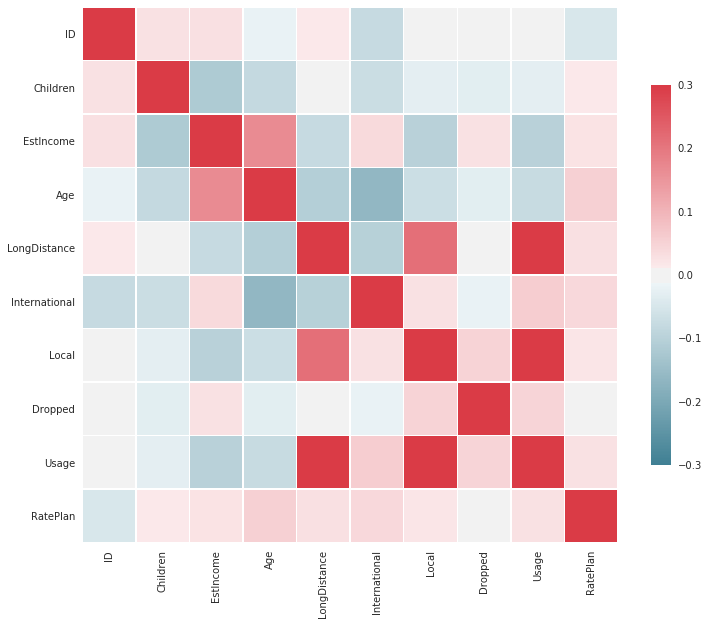

In [38]:
# Compute the correlation matrix
corr = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

### Visualizing multidimensional relationships

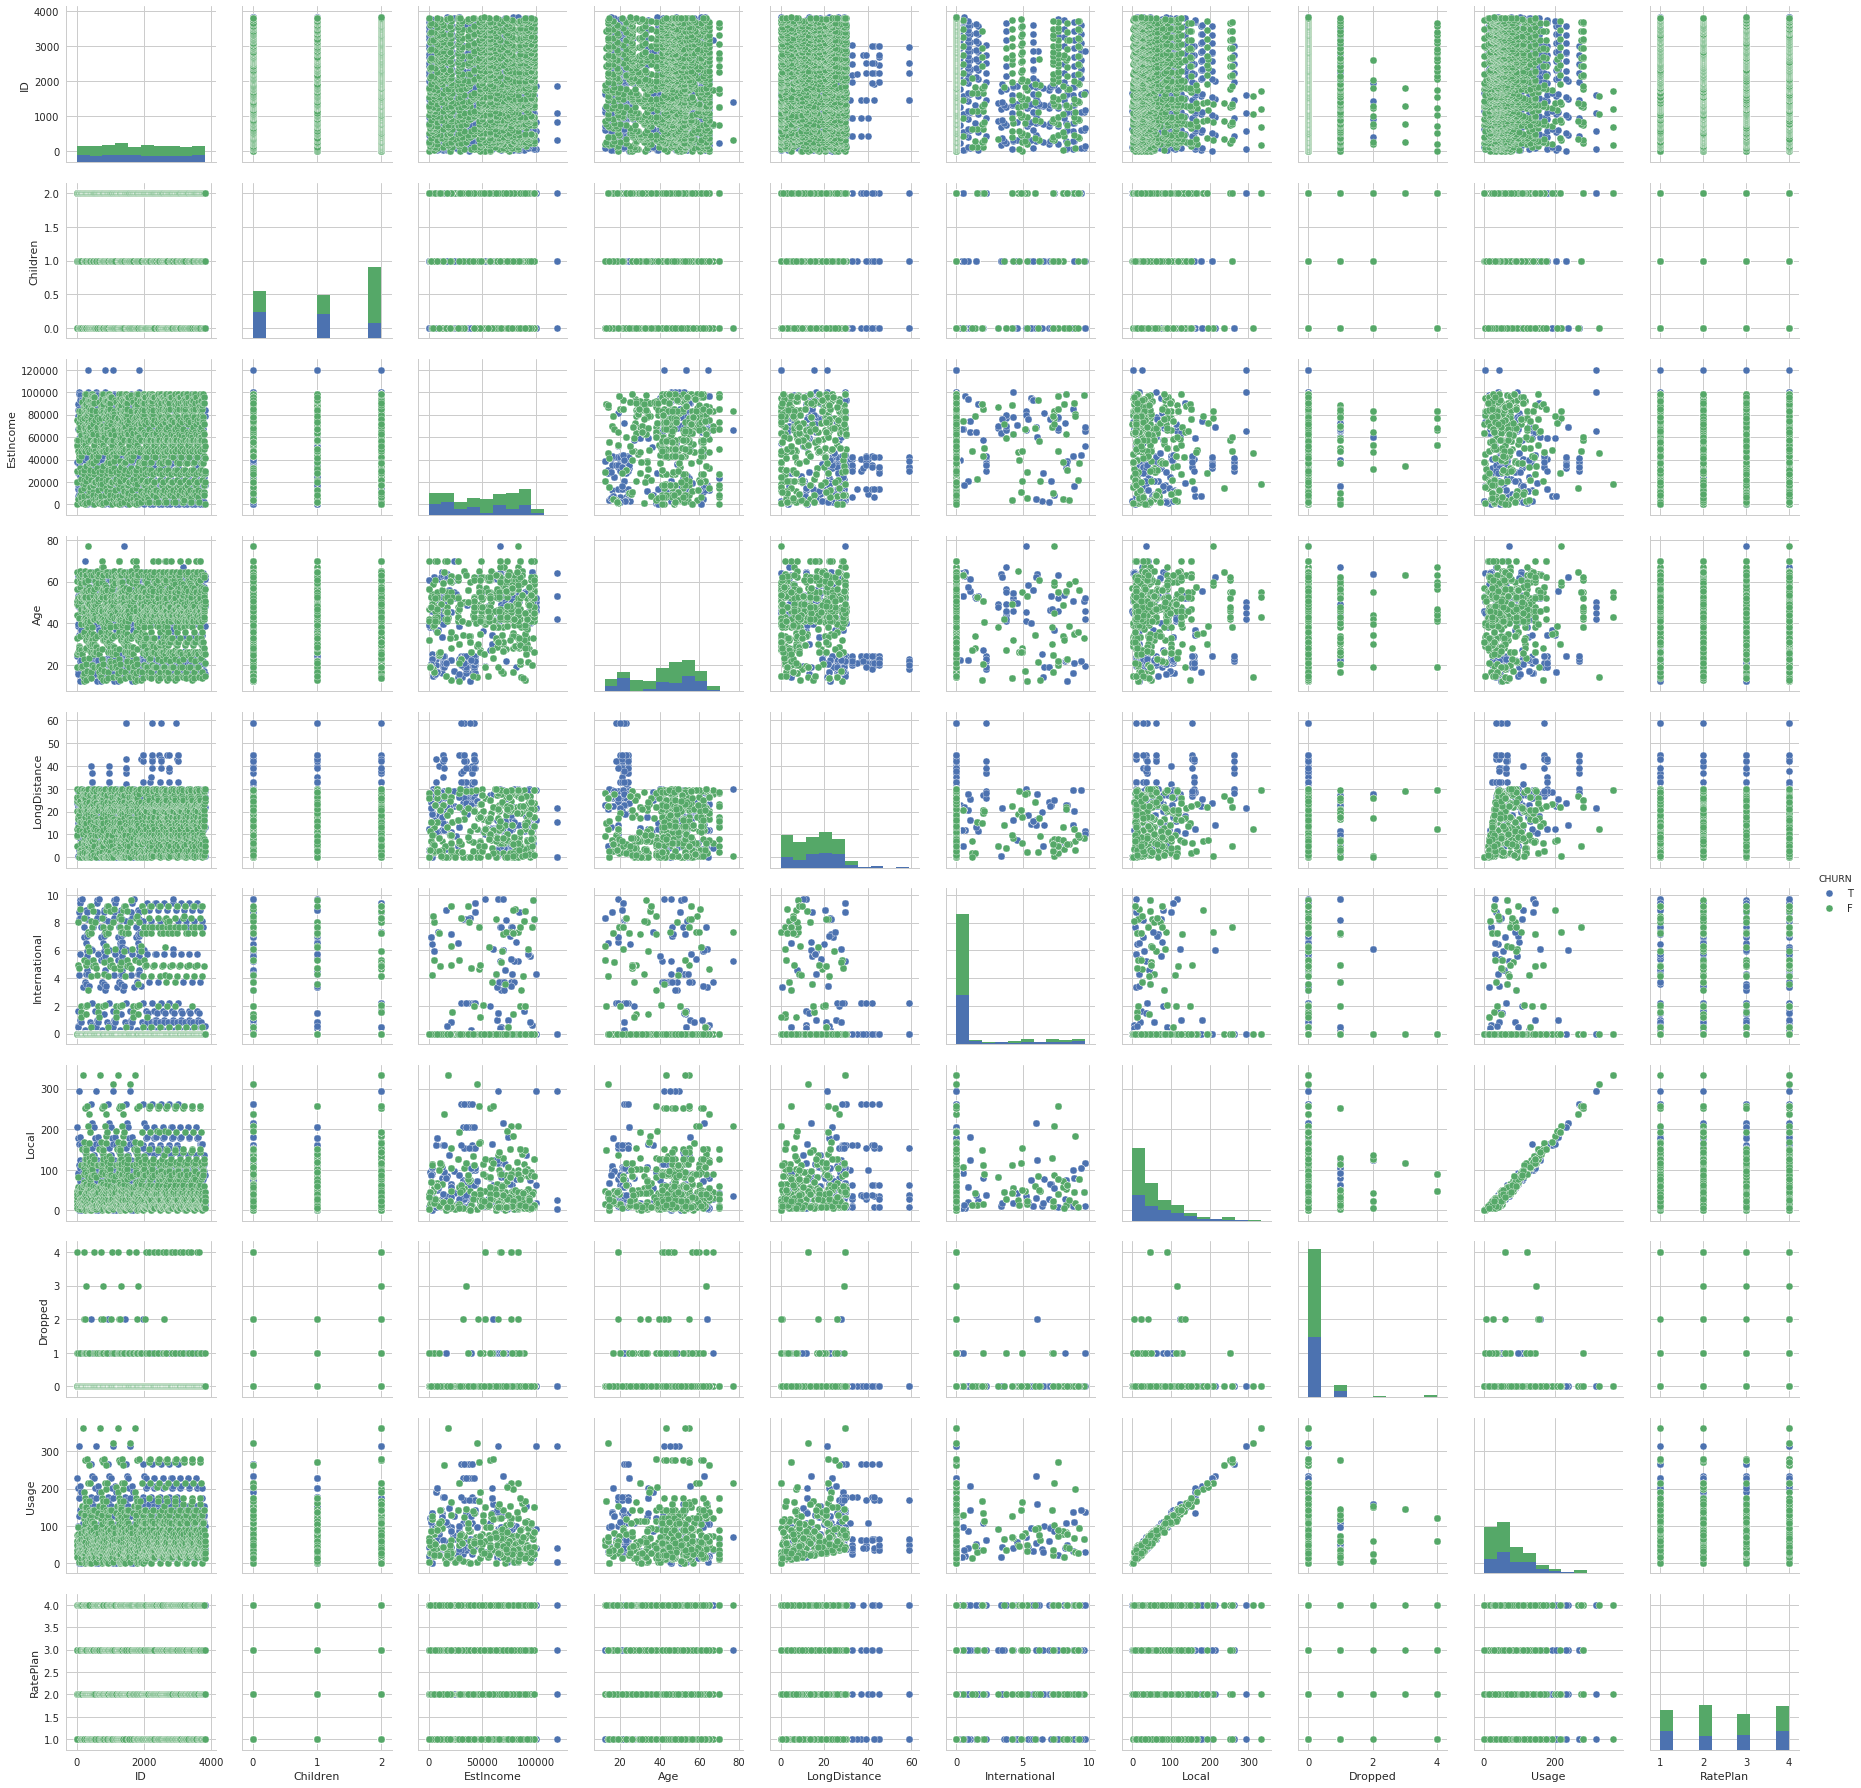

In [39]:
# pair plot
sns.pairplot(df, hue='CHURN', size=2.5);
plt.show()

#### Matplotlib example

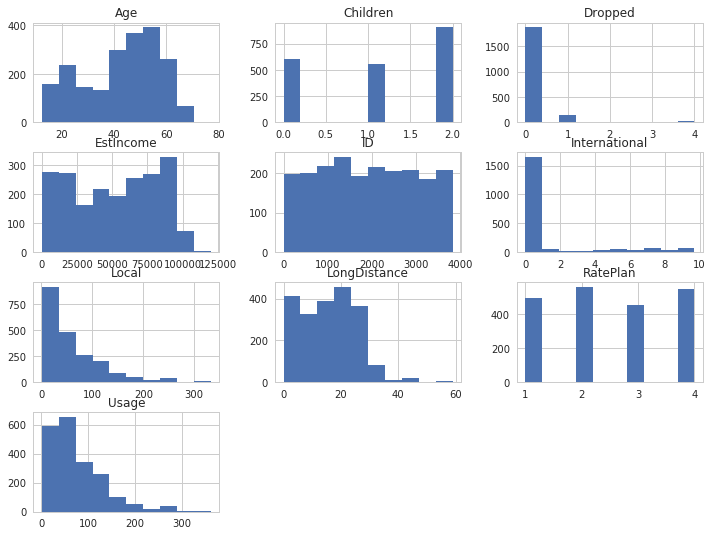

In [40]:
# histograms
df.hist()
plt.show()

### Show direct correlation between features

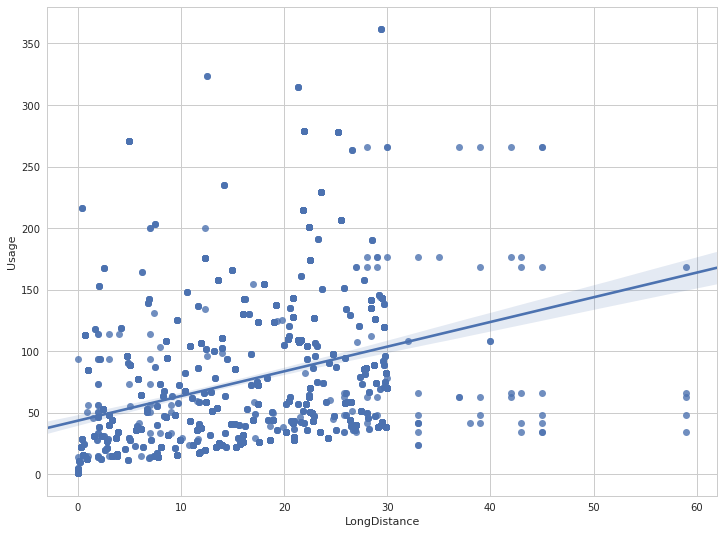

In [41]:
# stron correlation between Long Distance and Usage
sns.regplot(x="LongDistance", y="Usage", data=df)
plt.show()

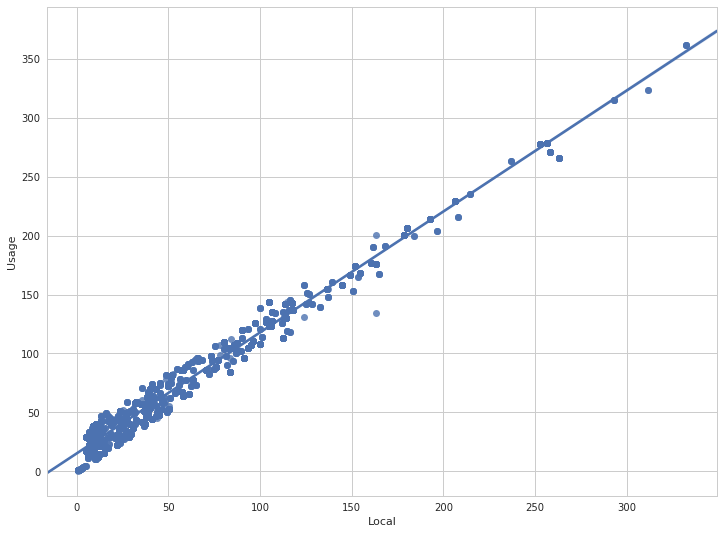

In [42]:
# stron correlation between Long Distance and Usage
sns.regplot(x="Local", y="Usage", data=df)
plt.show()

### Understanding statistical distribution

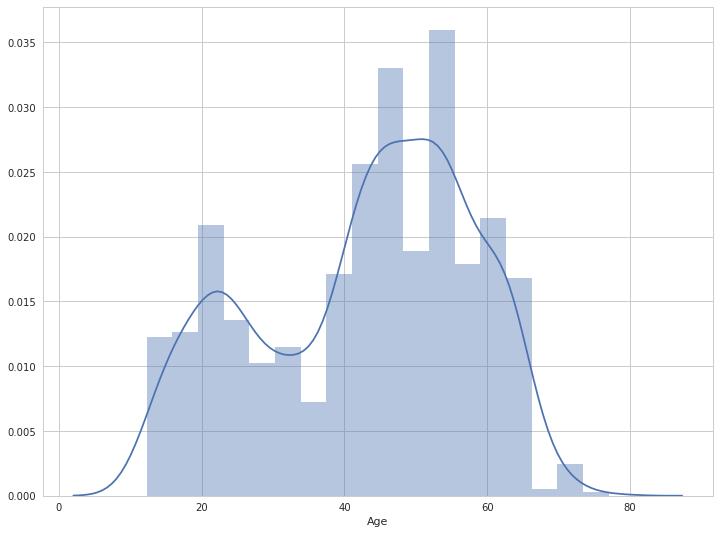

In [43]:
sns.distplot(df["Age"])
# show most user are in age 40 to 60

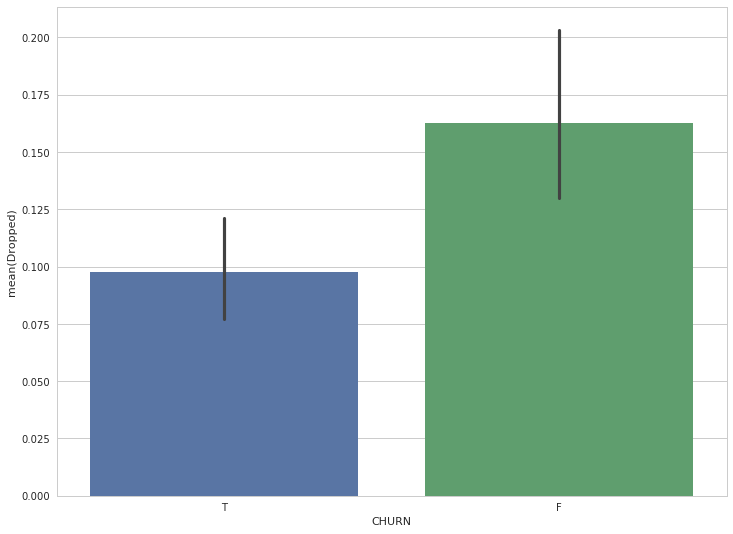

In [44]:
# bar chart shows age os no factor for churn
sns.barplot(x="CHURN", y="Dropped", data=df)

# IV: Model Building
## Step 6: Build  Spark Model Pipeline
"Pipeline" is an API in SparkML that's used for building models.
Additional information on SparkML: https://spark.apache.org/docs/2.0.2/ml-guide.html

In [45]:
# Prepare string variables so that they can be used by the decision tree algorithm
# StringIndexer encodes a string column of labels to a column of label indices
SI1 = StringIndexer(inputCol='Gender', outputCol='GenderEncoded')
SI2 = StringIndexer(inputCol='Status',outputCol='StatusEncoded')
SI3 = StringIndexer(inputCol='CarOwner',outputCol='CarOwnerEncoded')
SI4 = StringIndexer(inputCol='Paymethod',outputCol='PaymethodEncoded')
SI5 = StringIndexer(inputCol='LocalBilltype',outputCol='LocalBilltypeEncoded')
SI6 = StringIndexer(inputCol='LongDistanceBilltype',outputCol='LongDistanceBilltypeEncoded')

In [46]:
#encode the Label column
labelIndexer = StringIndexer(inputCol='CHURN', outputCol='label').fit(data)


# Pipelines API requires that input variables are passed in  a vector
assembler = VectorAssembler(inputCols=["GenderEncoded", "StatusEncoded", "CarOwnerEncoded", "PaymethodEncoded", "LocalBilltypeEncoded", \
                                       "LongDistanceBilltypeEncoded", "Children", "EstIncome", "Age", "LongDistance", "International", "Local",\
                                      "Dropped","Usage","RatePlan"], outputCol="features")

In [47]:
# instantiate the algorithm, take the default settings
rf=RandomForestClassifier(labelCol="label", featuresCol="features")

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

pipeline = Pipeline(stages=[SI1,SI2,SI3,SI4,SI5,SI6,labelIndexer, assembler, rf, labelConverter])

In [48]:
# Split data into train and test datasets
train, test = data.randomSplit([0.8,0.2], seed=6)
train.cache()
test.cache()

DataFrame[ID: int, Gender: string, Status: string, Children: double, EstIncome: double, CarOwner: string, Age: double, LongDistance: double, International: double, Local: double, Dropped: double, Paymethod: string, LocalBilltype: string, LongDistanceBilltype: string, Usage: double, RatePlan: double, CHURN: string]

## Model Training

In [49]:
# Build model. The fitted model from a Pipeline is a PipelineModel, which consists of fitted models and transformers, corresponding to the pipeline stages.
model = pipeline.fit(train)

## Step 7: Score the test data set

In [50]:
results = model.transform(test)
results=results.select(results["ID"],results["CHURN"],results["label"],results["predictedLabel"],results["prediction"],results["probability"])
results.toPandas().head(6)

,ID,CHURN,label,predictedLabel,prediction,probability
0,14,F,0.0,F,0.0,"[0.934380427555, 0.0656195724447]"
1,18,F,0.0,T,1.0,"[0.475330936101, 0.524669063899]"
2,21,F,0.0,F,0.0,"[0.661816827028, 0.338183172972]"
3,22,F,0.0,F,0.0,"[0.623563167565, 0.376436832435]"
4,29,T,1.0,T,1.0,"[0.283412151081, 0.716587848919]"
5,40,T,1.0,T,1.0,"[0.261455470103, 0.738544529897]"


# V: Model Building

## Step 8: Model Evaluation 

In [51]:
print 'Precision model1 = {:.2f}.'.format(results.filter(results.label == results.prediction).count() / float(results.count()))

Precision model1 = 0.92.


In [52]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")
print 'Area under ROC curve = {:.2f}.'.format(evaluator.evaluate(results))

Area under ROC curve = 0.92.


We have finished building and testing a predictive model. The next step is to deploy it for real time scoring. 

## Step 9: Save Model in ML repository

In [53]:
from repository.mlrepositoryclient import MLRepositoryClient
from repository.mlrepositoryartifact import MLRepositoryArtifact

In [54]:
service_path = 'https://internal-nginx-svc.ibm-private-cloud.svc.cluster.local:12443'
ml_repository_client = MLRepositoryClient()

Create the model artifact (abstraction layer).

<b>Tip:</b> The MLRepositoryArtifact method expects a trained model object, training data, and a model name. (It is this model name that is displayed by the Machine Learning service).


In [55]:
model_artifact = MLRepositoryArtifact(model, training_data=train, name="Telco-Churn-Demo")

Save pipeline and model artifacts to in Machine Learning repository:

In [56]:
saved_model = ml_repository_client.models.save(model_artifact)

In [8]:
# Print the saved model properties
print "modelType: " + saved_model.meta.prop("modelType")
print "creationTime: " + str(saved_model.meta.prop("creationTime"))
print "modelVersionHref: " + saved_model.meta.prop("modelVersionHref")
print "label: " + saved_model.meta.prop("label")
print "project id: " + str(saved_model.meta.prop('projectId'))

# VI: Model Testing

### Step 10:  Deploy and Test model with UI

1. Save the notebook and switch to the **Models** tab of the project (hint: open project with another tab in your browser). 
2. Under **Models**, find and click your model. Now, click on "Add Deployment" and use **Online deployment**.
3. Now use the **Test API** option to test the model on UI.

You can use the following data for testing: ID=99, Gender=M, Status=S, Children=0, Est Income=60000, Car Owner=Y, Age=34, LongDistance=68, International=50, Local=100, Dropped=0, Paymethod=CC, LocalBilltype=Budget, LongDistanceBilltype=Intnl_discount, Usage=334, RatePlan=3

The results of the test is displayed as follows:<br/>
<img style="float: left;" src="https://github.com/yfphoon/dsx_local/blob/master/images/Test_Model.png?raw=true" alt="Test API" width=900 />

### Step 11:  Test model with a REST API call (Optional)

This step is to demonstrate that you can make an external REST API call to test the model

* In the Deployment Details, copy the **scoring endpoint (remote access)** into your notepad. You can get **deployment endpoint** as well as **bearer token**.

* Alternatively, you can retreive the __bearer token__ for accessing your deployed model with this command: <br/>
`!curl -k -X GET https://load_balancer_ip/v2/identity/token -H "username: user" -H "password: Password"`

* Create and execute this command to invoke the model remotely:
<br/>
`!curl -i -k -X POST <Scoring Endpoint> -d '{fields}' "content-type: application/json" -H "authorization: Bearer <generate bearer token>"`

In [11]:
#insert your code here

!curl -i -k -X POST scoring_endpoint -d '{"ID":99,"Gender":"M","Status":"S","Children":0,"EstIncome":60000,"CarOwner":"Y","Age":34,"LongDistance":68,"International":50,"Local":100,"Dropped":0,"Paymethod":"CC","LocalBilltype":"Budget","LongDistanceBilltype":"Intnl_discount","Usage":334,"RatePlan":3}' -H "content-type: application/json" -H "authorization: Bearer Bearer_Token" 


## NiFi Invocation

The above REST endpoint can be invoked using Apache NiFi's InvokeHTTP for realtime scoring

![CRISP-DM](https://raw.githubusercontent.com/dhananjaymehta/IoTtrucking/master/nifi.png)

# VII: Model Management:

![CRISP-DM](https://raw.githubusercontent.com/dhananjaymehta/IoTtrucking/master/dashboard.png)